### 의사결정트리 알고리즘 학습 - 분류 + 교차검증


[1] 모듈 로딩 및 데이터 준비<hr>

In [301]:
## [1-1] 모듈로딩 
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

In [302]:
## [1-2] 데이터 준비
filename='iris.csv'

In [303]:
## 데이터 로딩 
irisDF= pd.read_csv(filename)
irisDF.head(2)

sepal.length  sepal.width  petal.length  petal.width variety
0           5.1          3.5           1.4          0.2  Setosa
1           4.9          3.0           1.4          0.2  Setosa

[2] 데이터 확인 <hr>

- 2개 품종만 추출 ==> 'Setosa', 'Versicolor'

In [304]:
## 품종 컬럼의 고유값 확인
irisDF.variety.unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

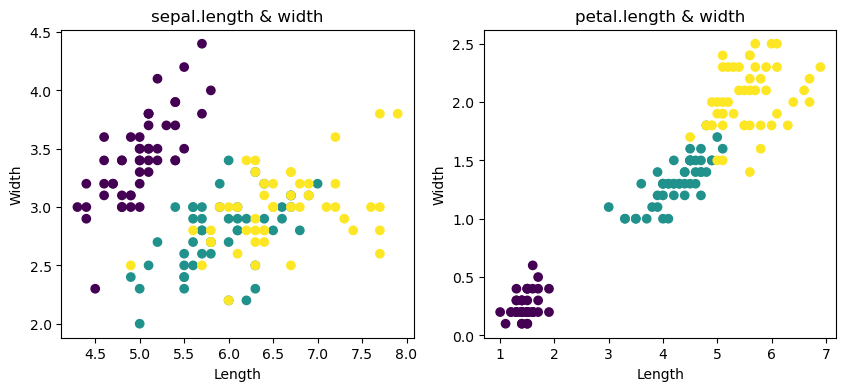

In [305]:
cols = [['sepal.length', 'sepal.width'], ['petal.length', 'petal.width']]
titles = ['sepal.length & width', 'petal.length & width']
colors = [ 0 if varient=='Setosa' else 1 if varient=='Versicolor' else 2 for varient in irisDF['variety']]

fig, axes = plt.subplots(1, 2,figsize=(10,4))
axes=axes.flatten()

for ax, (col1, col2), title in zip(axes, cols, titles):
    ax.scatter(irisDF[col1], irisDF[col2], c=colors)
    ax.set_xlabel('Length')
    ax.set_ylabel('Width')
    ax.set_title(title)
plt.show()

#### [2] 데이터 가공

- 피쳐/특성/독립과 타겟/클래스/종속변수 분리

In [306]:
featureDF = irisDF[irisDF.columns[:-1]]
targetSR = irisDF['variety']

In [307]:
print(f'featureDF : {featureDF.shape}  targetSR : {targetSR.shape}')

featureDF : (150, 4)  targetSR : (150,)


- 훈련용/테스트용 분리

In [308]:
## - 분류 시에는 훈련용/테스트용에 동일한 비율로 타겟이 배분 
## - stratify 매개변수 : 타겟 데이터셋의 클래스/라벨 비율에 맞게 학습용/테스트용 분리 
train_X, test_X, train_y, test_y = train_test_split(featureDF, targetSR,
                                                    random_state=7,
                                                    test_size=0.2,
                                                    stratify=targetSR)

In [309]:
print(f'[TRAIN] train_X : {train_X.shape}  train_y : {train_y.shape}')
print(f'[TEST] test_X : {test_X.shape}  test_y : {test_y.shape}')

[TRAIN] train_X : (120, 4)  train_y : (120,)
[TEST] test_X : (30, 4)  test_y : (30,)


In [310]:
## 데이터셋별로 클래스 갯수 확인
test_y.value_counts(), train_y.value_counts()

(variety
 Virginica     10
 Setosa        10
 Versicolor    10
 Name: count, dtype: int64,
 variety
 Virginica     40
 Setosa        40
 Versicolor    40
 Name: count, dtype: int64)

- 특성/피쳐 2개에 대한 스케일링 진행 ==> 피쳐의 값의 범위 일치

In [311]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder

In [312]:
## StandardScaler : 평균 0, 표준편차 1 즉, 정규분포 따르도록 스케일링
## 훈련용 DS기반의 스케일러는 테스트용 DS, 사용자 데이터에 대해 스케일링 진행 함
scaler = StandardScaler()

scaler.fit(train_X)


StandardScaler()

In [313]:
## fit() 후에 설정되는 파라미터들 ==> 모델 파라미터 
print(scaler.var_, scaler.mean_)

[0.7        0.18871597 3.1731     0.59086042] [5.85       3.06083333 3.78       1.2075    ]


In [314]:
# 훈련데이터와 테스트 데이터 스케일링 진행
# ==> 훈련용 생성한 스케일러로 훈련용, 테스트용 변환 진행 
# ==> 향후 임의의 새로운 데이터 예측(predict)시에도 해당 스케일러 적용
train_scaled_X = scaler.transform(train_X)
test_scaled_X = scaler.transform(test_X)

In [315]:
## LabelEncoder : 
lencoder = LabelEncoder()
lencoder.fit(targetSR)
print(lencoder.classes_)

['Setosa' 'Versicolor' 'Virginica']


In [316]:
targetSR=lencoder.transform(targetSR)

#### [3] 학습 
- 메인학습 : 지도학습 - 분류
- 세부학습 : Dicision Tree 알고리즘 => 다중분류 : 3개 품종 분류  

In [317]:
import graphviz
from sklearn.tree import DecisionTreeClassifier # 모델 클래스
from sklearn.tree import export_graphviz        # 모델 시각화 

In [318]:
# 학습 진행
# max_depth=2 : depth 조정 
dt_model = DecisionTreeClassifier(max_depth=2)
dt_model.fit(train_scaled_X, train_y)

DecisionTreeClassifier(max_depth=2)

In [319]:
# 학습 모델 시각화 파일 저장
export_graphviz(dt_model, out_file='iris_tree.dot',
                feature_names=train_X.columns,
                class_names=train_y.unique())

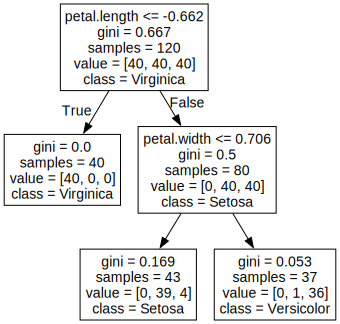

In [320]:
# 모델 파일 dot => 시각화 

# 파일 열기 (with as 구문 활용 파일 자동 닫힘)
with open('iris_tree.dot') as f:
    data = f.read()
    
# 파일에서 가져온 데이터 시각화 
graphviz.Source(data)

####  [4] 성능평가 <hr>

In [321]:
##  훈련용 성능과 테스트용 성능평가
## [1] 모델의 성능평가 메서드 : score()  accuracy로 성능평가 결과 반환
train_score = dt_model.score(train_scaled_X, train_y)
test_score = dt_model.score(test_scaled_X, test_y)

print(f'[Train] score : {train_score},  [Test] score : {test_score}')

[Train] score : 0.9583333333333334,  [Test] score : 0.9666666666666667


In [322]:
## [2] 다양한 성능평가 지표 
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

print('[TRAIN]------------------------')
train_pre = dt_model.predict(train_scaled_X)

print(f'정확도 : {accuracy_score(train_y, train_pre)}')
print(f'정밀도 : {precision_score(train_y, train_pre, average="macro")}')
print(f'재현율 : {recall_score(train_y, train_pre, average="macro")}')
print(f'f1점수 : {f1_score(train_y, train_pre, average="macro")}')

[TRAIN]------------------------
정확도 : 0.9583333333333334
정밀도 : 0.9599832390530064
재현율 : 0.9583333333333334
f1점수 : 0.9582746570698378


In [323]:
print('[TEST]------------------------')
test_pre = dt_model.predict(test_scaled_X)

print(f'정확도 : {accuracy_score(test_y, test_pre) }')
print(f'정밀도 : {precision_score(test_y, test_pre, average="macro") }')
print(f'재현율 : {recall_score(test_y, test_pre, average="macro") }')
print(f'f1점수 : {f1_score(test_y, test_pre, average="macro") }')

[TEST]------------------------
정확도 : 0.9666666666666667
정밀도 : 0.9696969696969697
재현율 : 0.9666666666666667
f1점수 : 0.9665831244778613


In [324]:
## [3] 손실/비용 계산 => 확률값으로 
from sklearn.metrics import log_loss
proba = dt_model.predict_proba(train_scaled_X)
probatest = dt_model.predict_proba(test_scaled_X)

train_loss = log_loss(train_y, proba)
test_loss = log_loss(test_y, probatest)

In [325]:
print(f'[Train Loss] {train_loss}  [Test Loss] {test_loss}')

[Train Loss] 0.14920670262253138  [Test Loss] 0.11992937393019548


# 교차 검증과 CV

In [326]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [327]:
# 하이퍼파라미터 dict 생성
param = {'max_depth' : [2,3,5], 'criterion' : ['gini', 'entropy', 'log_loss']}

# 모델 인스턴스 생성
t_model = DecisionTreeClassifier()

# 교차검증과 튜닝 진행 인스턴스 생성
gridCV = GridSearchCV(t_model, param, scoring=('accuracy'), refit='True')

In [328]:
gridCV.fit(train_scaled_X, train_y)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 5]},
             refit='True', scoring='accuracy')

In [329]:
# 교차 검증 및 튜닝 후 결과
print(f'가장 좋은 성능의 cv 번호 : {gridCV.best_index_}')
print(f'가장 좋은 성능의 하이퍼파라미터 조합 : {gridCV.best_params_}')
print(f'가장 좋은 성능의 점수 : {gridCV.best_score_}')
print(f'가장 좋은 성능의 재학습된 모델객체 : {gridCV.best_estimator_}')

가장 좋은 성능의 cv 번호 : 5
가장 좋은 성능의 하이퍼파라미터 조합 : {'criterion': 'entropy', 'max_depth': 5}
가장 좋은 성능의 점수 : 0.95
가장 좋은 성능의 재학습된 모델객체 : DecisionTreeClassifier(criterion='entropy', max_depth=5)


In [330]:
# 종합 정보 확인
gridCV.cv_results_

{'mean_fit_time': array([0.00157466, 0.00117984, 0.        , 0.00320168, 0.        ,
        0.00043573, 0.        , 0.00020156, 0.        ]),
 'std_fit_time': array([0.0022821 , 0.00217453, 0.        , 0.00590626, 0.        ,
        0.00053671, 0.        , 0.00040312, 0.        ]),
 'mean_score_time': array([0.        , 0.        , 0.        , 0.00070333, 0.        ,
        0.00243483, 0.        , 0.0025023 , 0.        ]),
 'std_score_time': array([0.        , 0.        , 0.        , 0.00058379, 0.        ,
        0.00438704, 0.        , 0.00446205, 0.        ]),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'entropy', 'entropy',
                    'entropy', 'log_loss', 'log_loss', 'log_loss'],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value=np.str_('?'),
             dtype=object),
 'param_max_depth': masked_array(data=[2, 3, 5, 2, 3, 5, 2, 3, 5],
              mask=[False, False, False, 

In [331]:
# 가장 좋은 모델
best_model = gridCV.best_estimator_

In [332]:
# 사용자 입력 데이터 => 모델 데이터 형태 
user_data = pd.DataFrame([[1.4, 0.8, 3.4, 1.3]], columns=featureDF.columns)
user_data_ = scaler.transform(user_data)

In [333]:
# 모델로 예측하기
best_model.predict(user_data_)

array(['Versicolor'], dtype=object)

# Decision Tree의 장점

1. 피쳐 중요도 확인할 때

In [334]:
# Decision Tree의 모델 파라미터 : 피쳐 중요도 확인 
best_model.feature_importances_

array([0.        , 0.0105155 , 0.64407648, 0.34540802])

In [335]:
for f_name, f_importances in zip(train_X.columns, best_model.feature_importances_):
    print(f_name, f_importances)
    

sepal.length 0.0
sepal.width 0.010515495892857624
petal.length 0.6440764816667752
petal.width 0.34540802244036717
